In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer


import sys
sys.path.append("/Users/vedantzope/Desktop/Maternal-and-Child-Health-Monitoring-in-LMICs")
from modules.functions import *


# Load the dataset
data = load_data("abc-2.csv")


# Define the labels
labels = ['Mean_BMI', 'Median_BMI', 'Unmet_Need_Rate', 'Under5_Mortality_Rate', 'Skilled_Birth_Attendant_Rate', 'Stunted_Rate']

# Split the data into training and validation sets
X = data.drop(columns=labels)
y = data[labels]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define MCRMSE for evaluation
def mcrmse(y_true, y_pred):
    return np.mean(np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values')))


def knn_impute(X_train, X_val):
    imputer = KNNImputer(n_neighbors=5)
    X_train_imputed = imputer.fit_transform(X_train.select_dtypes(include=['float64', 'int64']))
    X_val_imputed = imputer.transform(X_val.select_dtypes(include=['float64', 'int64']))
    return pd.DataFrame(X_train_imputed, columns=X_train.select_dtypes(include=['float64', 'int64']).columns), pd.DataFrame(X_val_imputed, columns=X_val.select_dtypes(include=['float64', 'int64']).columns)


def hierarchical_impute(df, numerical_cols):
    df_imputed = df.copy()
    for code in df['Country_Code'].unique():
        subset = df[df['Country_Code'] == code]
        subset_imputed = subset.fillna(subset.mean(numeric_only=True))
        df_imputed.update(subset_imputed)

    for region in df['target_region'].unique():
        subset = df[df['target_region'] == region]
        subset_imputed = subset.fillna(subset.mean(numeric_only=True))
        df_imputed.update(subset_imputed)

    return df_imputed.fillna(df.mean(numeric_only=True))


def hierarchical_knn_impute(df, numerical_cols):
    df_imputed = df.copy()
    imputer = KNNImputer(n_neighbors=5)
    
    # Country-level imputation
    for code in df['Country_Code'].unique():
        mask = df['Country_Code'] == code
        subset = df[mask]
        
        # Identify columns in this subset that have missing values and are also in numerical_cols
        cols_to_impute = subset.columns[subset.isnull().any()].intersection(numerical_cols).tolist()
        
        # Check if all values are missing in the subset for these columns
        all_missing = subset[cols_to_impute].isnull().all()
        cols_with_some_data = all_missing[~all_missing].index.tolist()
        
        if cols_with_some_data:
            subset_imputed = imputer.fit_transform(subset[cols_with_some_data])
            df_imputed.loc[mask, cols_with_some_data] = subset_imputed
            
    # Region-level imputation for remaining missing values
    for region in df['target_region'].unique():
        mask = (df['target_region'] == region) & (df[numerical_cols].isnull().any(axis=1))
        subset = df[mask]
        
        # Identify columns in this subset that have missing values and are also in numerical_cols
        cols_to_impute = subset.columns[subset.isnull().any()].intersection(numerical_cols).tolist()
        
        # Check if all values are missing in the subset for these columns
        all_missing = subset[cols_to_impute].isnull().all()
        cols_with_some_data = all_missing[~all_missing].index.tolist()
        
        if cols_with_some_data:
            subset_imputed = imputer.fit_transform(subset[cols_with_some_data])
            df_imputed.loc[mask, cols_with_some_data] = subset_imputed

    # Global imputation for any remaining missing values
    global_missing_cols = df[numerical_cols].columns[df[numerical_cols].isnull().any()].tolist()
    if global_missing_cols:
        df_imputed[global_missing_cols] = imputer.fit_transform(df[global_missing_cols])
    
    return df_imputed


# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# print("Starting KNN Imputation...")
# X_train_knn, X_val_knn = knn_impute(X_train, X_val)

# print("Starting Hierarchical Imputation...")
# X_train_hierarchical = hierarchical_impute(X_train, numerical_cols)
# X_val_hierarchical = hierarchical_impute(X_val, numerical_cols)

# print("Starting Hierarchical KNN Imputation...")
# X_train_hierarchical_knn = hierarchical_knn_impute(X_train, numerical_cols)
# X_val_hierarchical_knn = hierarchical_knn_impute(X_val, numerical_cols)

# Train and evaluate model for each imputation method
# import xgboost as xgb

# def train_and_evaluate(X_train, X_val, y_train, y_val):
#     # Only select numerical columns for training
#     X_train = X_train.select_dtypes(include=['int64', 'float64'])
#     X_val = X_val.select_dtypes(include=['int64', 'float64'])
    
#     model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100)
#     model.fit(X_train, y_train)
#     preds = model.predict(X_val)
#     return mcrmse(y_val, preds)

In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def iterative_impute(X_train, X_val):
    imputer = IterativeImputer(max_iter=10, random_state=0)
    
    # Only select numerical columns for imputation
    X_train_numeric = X_train[numerical_cols]
    X_val_numeric = X_val[numerical_cols]
    
    X_train_imputed = imputer.fit_transform(X_train_numeric)
    X_val_imputed = imputer.transform(X_val_numeric)
    
    # Convert the imputed data back to DataFrame
    X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=numerical_cols)
    X_val_imputed_df = pd.DataFrame(X_val_imputed, columns=numerical_cols)
    
    # Update the original dataframes with imputed values
    X_train.update(X_train_imputed_df)
    X_val.update(X_val_imputed_df)

    return X_train, X_val


print("Starting Iterative Imputation...")
X_train_iterative, X_val_iterative = iterative_impute(X_train, X_val)



Starting Iterative Imputation...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [2]:
pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


Defaulting to user installation because normal site-packages is not writeable
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm  # Modify this import
from sklearn.impute import KNNImputer
import xgboost as xgb
# Define the range for n_neighbors
n_neighbors_values = [3, 5, 7, 10, 15]
mae_results = []

# Loop over each n_neighbors value
for i,n_neighbors in enumerate(n_neighbors_values):
    print(i)
    # Impute using KNN
    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_train_imputed = imputer.fit_transform(X_train.select_dtypes(include=['int64', 'float64']))
    X_val_imputed = imputer.transform(X_val.select_dtypes(include=['int64', 'float64']))
    
    # Train XGBoost on imputed data
    model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100)
    model.fit(X_train_imputed, y_train)
    preds = model.predict(X_val_imputed)
    
    # Evaluate and store result
    mae = mean_absolute_error(y_val, preds)
    mae_results.append(mae)
    print(f"{i} done")

mae_results


0
0 done
1
1 done
2
2 done
3
3 done
4
4 done


[8.54213766100301,
 8.547541688254928,
 8.528106733099484,
 8.552726535784577,
 8.516395843273909]

0
0 done
1
1 done
2
2 done
3
3 done
4
4 done
5
5 done


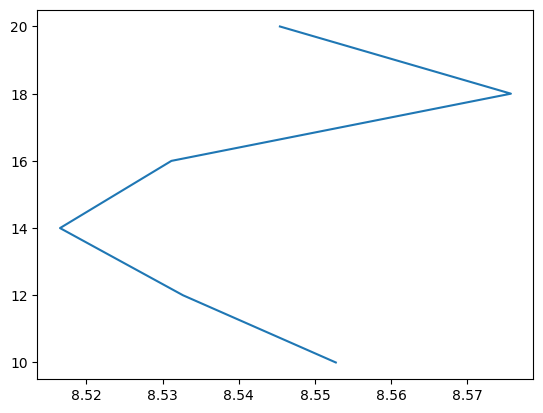

In [12]:
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm  # Modify this import
from sklearn.impute import KNNImputer
import xgboost as xgb
# Define the range for n_neighbors
n_neighbors_values = [10, 12, 14, 16, 18,20]
mae_results = []

# Loop over each n_neighbors value
for i,n_neighbors in enumerate(n_neighbors_values):
    print(i)
    # Impute using KNN
    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_train_imputed = imputer.fit_transform(X_train.select_dtypes(include=['int64', 'float64']))
    X_val_imputed = imputer.transform(X_val.select_dtypes(include=['int64', 'float64']))
    
    # Train XGBoost on imputed data
    model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100)
    model.fit(X_train_imputed, y_train)
    preds = model.predict(X_val_imputed)
    
    # Evaluate and store result
    mae = mean_absolute_error(y_val, preds)
    mae_results.append(mae)
    print(f"{i} done")

mae_results
plt.plot(mae_results,n_neighbors_values)


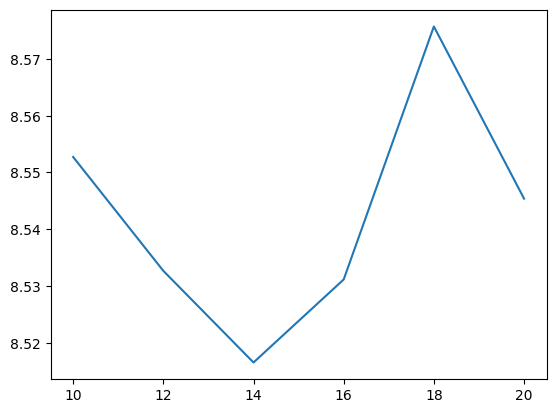

In [13]:
import matplotlib.pyplot as plt
plt.plot(n_neighbors_values,mae_results)


In [25]:
print("NaN values in X_train_iterative:", X_train_iterative.isnull().sum().sum())
print("NaN values in X_val_iterative:", X_val_iterative.isnull().sum().sum())

print("Inf values in X_train_iterative:", (X_train_iterative == np.inf).sum().sum() + (X_train_iterative == -np.inf).sum().sum())
print("Inf values in X_val_iterative:", (X_val_iterative == np.inf).sum().sum() + (X_val_iterative == -np.inf).sum().sum())


NaN values in X_train_iterative: 71487
NaN values in X_val_iterative: 62314
Inf values in X_train_iterative: 0
Inf values in X_val_iterative: 0


In [26]:
print("NaN values in X_train_iterative:", X_train.isnull().sum().sum())
print("NaN values in X_val_iterative:", X_val.isnull().sum().sum())

print("Inf values in X_train_iterative:", (X_train_iterative == np.inf).sum().sum() + (X_train_iterative == -np.inf).sum().sum())
print("Inf values in X_val_iterative:", (X_val_iterative == np.inf).sum().sum() + (X_val_iterative == -np.inf).sum().sum())


NaN values in X_train_iterative: 71487
NaN values in X_val_iterative: 62314
Inf values in X_train_iterative: 0
Inf values in X_val_iterative: 0


In [19]:
from sklearn.linear_model import LinearRegression

# def train_and_evaluate(X_train, X_val, y_train, y_val):
#     # Only select numerical columns for training
#     X_train = X_train.select_dtypes(include=['int64', 'float64'])
#     X_val = X_val.select_dtypes(include=['int64', 'float64'])
    
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     preds = model.predict(X_val)
#     return mcrmse(y_val, preds)

import xgboost as xgb

def train_and_evaluate(X_train, X_val, y_train, y_val):
    # Only select numerical columns for training
    X_train = X_train.select_dtypes(include=['int64', 'float64'])
    X_val = X_val.select_dtypes(include=['int64', 'float64'])
    
    model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return mcrmse(y_val, preds)

print("Evaluating KNN Imputation...")
mae_knn = train_and_evaluate(X_train_knn, X_val_knn, y_train, y_val)
print(mae_knn)
print(50*"*")

print("Evaluating Hierarchical Imputation...")
mae_hierarchical = train_and_evaluate(X_train_hierarchical, X_val_hierarchical, y_train, y_val)
print(mae_hierarchical)
print(50*"*")

print("Evaluating Hierarchical KNN Imputation...")
mae_hierarchical_knn = train_and_evaluate(X_train_hierarchical_knn, X_val_hierarchical_knn, y_train, y_val)
print(mae_hierarchical_knn)
print(50*"*")

print(f"MCRMSE for KNN Imputation: {mae_knn}")
print(f"MCRMSE for Hierarchical Imputation: {mae_hierarchical}")
print(f"MCRMSE for Hierarchical KNN Imputation: {mae_hierarchical_knn}")

Evaluating KNN Imputation...
11.364360870330371
**************************************************
Evaluating Hierarchical Imputation...
11.407398119301215
**************************************************
Evaluating Hierarchical KNN Imputation...
11.377766267443336
**************************************************
MCRMSE for KNN Imputation: 11.364360870330371
MCRMSE for Hierarchical Imputation: 11.407398119301215
MCRMSE for Hierarchical KNN Imputation: 11.377766267443336


In [17]:
import pandas as pd


from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
import numpy as np

# Dictionary to store MAE scores for KNN Imputer
mae_scores_knn = {}

selected_columns = [
 'Literacy rate, youth total (% of people ages 15-24)',
 'School enrollment, primary and secondary (gross), gender parity index (GPI)',
 'Unmet need for contraception (% of married women ages 15-49)',
 'Pregnant women receiving prenatal care (%)',
 'Prevalence of overweight, weight for height (% of children under 5)',
 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Prevalence of undernourishment (% of population)'
]
n_neighbors_val = [5,10,13,17,20,25]

for n in tqdm(n_neighbors_val):

    # Apply KNN Imputer and validate
    knn_imputer = KNNImputer(n_neighbors=n)

    for column in selected_columns:
        # Create a copy of the data
        df_temp = load_data("df_temp_pseudo_missing.csv")
        
        # Find indices of non-missing values
        non_missing_idx = df_temp[df_temp[column].notnull()].index.tolist()
        
        # Randomly select 10% of these indices
        random_idx = np.random.choice(non_missing_idx, size=int(0.1 * len(non_missing_idx)), replace=False)
        
        # Store the original values and then replace them with NaN
        original_values = df_temp.loc[random_idx, column].values
        df_temp.loc[random_idx, column] = np.nan
        
        # Apply KNN imputer
        imputed_values = knn_imputer.fit_transform(df_temp[[column]])
        
        # Calculate MAE between original and imputed values
        mae = mean_absolute_error(original_values, imputed_values[random_idx])
        mae_scores_knn[column] = mae
    print(f"n_neighbors={n}")
    print(mae_scores_knn)
    print(50*"*")


 17%|█▋        | 1/6 [00:48<04:00, 48.14s/it]

n_neighbors=5
{'Literacy rate, youth total (% of people ages 15-24)': 11.652083866113683, 'School enrollment, primary and secondary (gross), gender parity index (GPI)': 0.050768770104657995, 'Unmet need for contraception (% of married women ages 15-49)': 6.453057706387723, 'Pregnant women receiving prenatal care (%)': 9.660102366928694, 'Prevalence of overweight, weight for height (% of children under 5)': 3.1421064492459765, 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)': 15.156040696885494, 'Population in urban agglomerations of more than 1 million (% of total population)': 8.757318129620279, 'Prevalence of undernourishment (% of population)': 6.234163696450712}
**************************************************


 33%|███▎      | 2/6 [01:44<03:32, 53.21s/it]

n_neighbors=10
{'Literacy rate, youth total (% of people ages 15-24)': 11.876478555480938, 'School enrollment, primary and secondary (gross), gender parity index (GPI)': 0.05163905909650261, 'Unmet need for contraception (% of married women ages 15-49)': 6.457440805702853, 'Pregnant women receiving prenatal care (%)': 9.69555006411551, 'Prevalence of overweight, weight for height (% of children under 5)': 3.3364979751588297, 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)': 15.46515197646038, 'Population in urban agglomerations of more than 1 million (% of total population)': 8.914973168969505, 'Prevalence of undernourishment (% of population)': 6.33618553580896}
**************************************************


 50%|█████     | 3/6 [02:45<02:49, 56.45s/it]

n_neighbors=13
{'Literacy rate, youth total (% of people ages 15-24)': 11.811494551719724, 'School enrollment, primary and secondary (gross), gender parity index (GPI)': 0.05035896381451397, 'Unmet need for contraception (% of married women ages 15-49)': 6.464851649728904, 'Pregnant women receiving prenatal care (%)': 9.519090105455325, 'Prevalence of overweight, weight for height (% of children under 5)': 3.158236349334521, 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)': 15.484841049268036, 'Population in urban agglomerations of more than 1 million (% of total population)': 8.78192553229195, 'Prevalence of undernourishment (% of population)': 6.327388354892833}
**************************************************


 67%|██████▋   | 4/6 [03:30<01:44, 52.10s/it]

n_neighbors=17
{'Literacy rate, youth total (% of people ages 15-24)': 11.91416856561328, 'School enrollment, primary and secondary (gross), gender parity index (GPI)': 0.050565336628847816, 'Unmet need for contraception (% of married women ages 15-49)': 6.588917725764042, 'Pregnant women receiving prenatal care (%)': 9.678715064593113, 'Prevalence of overweight, weight for height (% of children under 5)': 3.220172136605161, 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)': 15.31410904314623, 'Population in urban agglomerations of more than 1 million (% of total population)': 8.991233352071573, 'Prevalence of undernourishment (% of population)': 6.2442630319823484}
**************************************************


 83%|████████▎ | 5/6 [04:16<00:49, 49.81s/it]

n_neighbors=20
{'Literacy rate, youth total (% of people ages 15-24)': 12.022348800747702, 'School enrollment, primary and secondary (gross), gender parity index (GPI)': 0.05108804096895952, 'Unmet need for contraception (% of married women ages 15-49)': 6.54371637239477, 'Pregnant women receiving prenatal care (%)': 9.729070353583074, 'Prevalence of overweight, weight for height (% of children under 5)': 3.237611583296567, 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)': 15.468667324671138, 'Population in urban agglomerations of more than 1 million (% of total population)': 8.948723529199526, 'Prevalence of undernourishment (% of population)': 6.096346858888343}
**************************************************


100%|██████████| 6/6 [05:03<00:00, 50.61s/it]

n_neighbors=25
{'Literacy rate, youth total (% of people ages 15-24)': 11.59810246792182, 'School enrollment, primary and secondary (gross), gender parity index (GPI)': 0.051189222013982266, 'Unmet need for contraception (% of married women ages 15-49)': 6.445671059636488, 'Pregnant women receiving prenatal care (%)': 9.669312140798048, 'Prevalence of overweight, weight for height (% of children under 5)': 3.187211279438255, 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)': 15.35411019152848, 'Population in urban agglomerations of more than 1 million (% of total population)': 8.817367854835824, 'Prevalence of undernourishment (% of population)': 6.2182019811138725}
**************************************************


In [19]:
pwd

'/Users/vedantzope/Desktop/Maternal-and-Child-Health-Monitoring-in-LMICs/notebooks'

In [23]:
labels

['Mean_BMI',
 'Median_BMI',
 'Unmet_Need_Rate',
 'Under5_Mortality_Rate',
 'Skilled_Birth_Attendant_Rate',
 'Stunted_Rate']

In [43]:
labels = labels_list()
# Load the data
df = pd.read_csv('wbdata+gee.csv')

# Process for 'Country_Code' and 'target_region' columns
df = country_region_mapping(df)
df['is_train'] = ~df['Under5_Mortality_Rate'].isna()
df=one_hot_encode(df,['Country_Code','URBAN_RURA'])
df.drop(columns=['WB_Country_Code','target_region','DHSID'],inplace=True)
print_obj_columns(df)

[]


In [54]:
pwd

'/Users/vedantzope/Desktop/Maternal-and-Child-Health-Monitoring-in-LMICs/notebooks'

In [68]:
import sys
sys.path.append("/Users/vedantzope/Desktop/Maternal-and-Child-Health-Monitoring-in-LMICs/modules")

import importlib
from modules.functions import *
import pandas as pd
import os

df = load_csv_data("../data/interim/top120_geetl.csv")
wbdata = load_csv_data("../data/external/wb_data_features/features_wbdata.csv")

merged_df = merge_dataframes(df,wbdata)
labels =labels_list()

merged_df.dropna(subset=labels,inplace = True)
merged_df.reset_index(drop = True, inplace = True)

In [69]:
merged_df

,bio18_max@WORLDCLIM/V1/BIO,Solar_Zenith_Mean_Mean_median@MODIS/061/MOD08_M3&timestamped,Solar_Zenith_Mean_Mean_mean@MODIS/061/MOD08_M3&timestamped,URBAN_RURA,Lifted_Index_Mean_Mean_min_min@MODIS/061/MOD08_M3&timestamped,LONGNUM,FparLai_QC_min_max@MODIS/006/MOD15A2H&timestamped,urban-coverfraction_mean@COPERNICUS/Landcover/100m/Proba-V-C3/Global&timestamped,SO2_column_number_density_amf_mean@COPERNICUS/S5P/NRTI/L3_SO2&timestamped,valid_obs@JRC/GSW1_2/Metadata,...,Population density (people per sq. km of land area),Urban population living in areas where elevation is below 5 meters (% of total population),Population living in areas where elevation is below 5 meters (% of total population),Population living in slums (% of urban population),Population in the largest city (% of urban population),Population in urban agglomerations of more than 1 million,"Population, total","Population, female (% of total)","Population, male (% of total)",Rural population (% of total population)
0,101.0,4295.0,4327.6665,R,277.0,19.838322,0.0,15.942918,0.396530,239.86597,...,107.566204,NaN,NaN,17.9,26.709050,NaN,2947314.0,50.040062,49.959938,50.009
1,111.0,4292.0,4326.4395,R,277.0,20.007555,0.0,1.059678,0.418226,445.95758,...,107.566204,NaN,NaN,17.9,26.709050,NaN,2947314.0,50.040062,49.959938,50.009
2,100.0,4295.0,4327.6665,R,277.0,19.863338,0.0,10.031118,0.405932,263.04514,...,107.566204,NaN,NaN,17.9,26.709050,NaN,2947314.0,50.040062,49.959938,50.009
3,116.0,4295.0,4327.6665,U,277.0,19.950300,157.0,22.716291,0.408865,427.90918,...,107.566204,NaN,NaN,17.9,26.709050,NaN,2947314.0,50.040062,49.959938,50.009
4,107.0,4295.0,4327.6665,U,277.0,19.935875,157.0,41.684960,0.407028,417.52830,...,107.566204,NaN,NaN,17.9,26.709050,NaN,2947314.0,50.040062,49.959938,50.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36675,279.0,3153.5,3333.4167,R,-55.0,29.718370,0.0,0.000000,0.715033,767.83370,...,36.590247,0.0,0.0,NaN,32.715928,1499723.0,14154937.0,52.999890,47.000110,67.615
36676,317.0,3168.0,3356.4167,U,141.0,31.156115,157.0,80.522360,0.723455,948.45197,...,36.590247,0.0,0.0,NaN,32.715928,1499723.0,14154937.0,52.999890,47.000110,67.615
36677,330.0,3218.5,3393.5833,R,227.0,31.872288,0.0,0.298818,0.747981,461.03748,...,36.590247,0.0,0.0,NaN,32.715928,1499723.0,14154937.0,52.999890,47.000110,67.615
36678,289.0,3033.5,3238.4167,R,-22.0,29.850649,0.0,0.000000,0.765019,733.50696,...,36.590247,0.0,0.0,NaN,32.715928,1499723.0,14154937.0,52.999890,47.000110,67.615


In [46]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Calculate percentage of missing data for each column
missing_percentage = df.isnull().sum() * 100 / len(df)

# Get columns with more than 30% missing data
cols_gt_30 = missing_percentage[missing_percentage > 30].index.tolist()

# Splitting the data into training and validation sets
df_train = df[df['is_train'] == True].drop(columns=['is_train'])
df_val = df[df['is_train'] == False].drop(columns=['is_train'])

# Separate the labels
labels_train = df_train[labels]
df_train = df_train.drop(columns=labels)
labels_val = df_val[labels]
df_val = df_val.drop(columns=labels)

df_train.drop(columns=['WB_Country_Code','target_region','DHSID'],inplace=True)

df_val.drop(columns=['WB_Country_Code','target_region','DHSID'],inplace=True)
# Lists to hold results
mae_results_gt_30_xgb = {}
mae_results_gt_30_rf = {}

for col in tqdm(cols_gt_30):
    
    # Prepare data for this column
    X_train_col = df_train.dropna(subset=[col]).drop(columns=col)
    y_train_col = df_train.dropna(subset=[col])[col]
    X_val_col = df_val.drop(columns=col)
    y_val_col = df_val[col]
    
    # Imputation using Linear Regression

    model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred_lr = model.predict(X_val_col)
    mae_lr = mean_absolute_error(y_val_col, y_pred_lr)
    mae_results_gt_30_xgb[col] = mae_lr
    
    # # Imputation using Random Forest
    # rf = RandomForestRegressor(n_estimators=50, random_state=42)
    # rf.fit(X_train_col, y_train_col)
    # y_pred_rf = rf.predict(X_val_col)
    # mae_rf = mean_absolute_error(y_val_col, y_pred_rf)
    # mae_results_gt_30_rf[col] = mae_rf

print("Linear Regression Results:", mae_results_gt_30_xgb)
#print("Random Forest Results:", mae_results_gt_30_rf)


KeyError: "['WB_Country_Code', 'target_region', 'DHSID'] not found in axis"